# VitalDB model check

This exemple compare the data from the open source vitalDB database and the model included in PAS.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import python_anesthesia_simulator as pas
import vitaldb as vdb
import pandas as pd

## Import data from vitalDB

All the documentation about the vitaldb package is available [here](https://vitaldb.net/docs/?documentId=1j702xfDef7RNhfZANQQt7tkzzbin2FVe9GAnleDSyzI).

In [11]:
case_id = 47 # case id  47
ts = 1 # sampling time in seconds
track_name = ['BIS/BIS', 'Orchestra/PPF20_RATE', 'Orchestra/RFTN20_RATE',
              'Orchestra/PPF20_CE', 'Orchestra/RFTN20_CE', 'Solar8000/ART_MBP',
              'BIS/SQI', 'Solar8000/PLETH_HR', 'Orchestra/PPF20_CP',
              'Orchestra/RFTN20_CP'] # track names to import
case = vdb.VitalFile(case_id, track_name) # load case
case_df = case.to_pandas(track_name, ts) # convert to pandas dataframe
# fill missing values
case_df['Orchestra/PPF20_RATE'] = case_df['Orchestra/PPF20_RATE'].bfill()
case_df['Orchestra/RFTN20_RATE'] = case_df['Orchestra/RFTN20_RATE'].bfill()

## Replay input data in the simulator

An instance of the Simulator is created for the patient with the specific information.
Then we run the simulation using the drug rates as input (in the relevant units).

In [12]:
perso_data = pd.read_csv("https://api.vitaldb.net/cases", decimal='.') # load personal data of the case
age = float(perso_data[perso_data['caseid'] == case_id]['age'].iloc[0])
height = float(perso_data[perso_data['caseid'] == case_id]['height'].iloc[0])
weight = float(perso_data[perso_data['caseid'] == case_id]['weight'].iloc[0])
gender = int(perso_data[perso_data['caseid'] == case_id]['sex'].iloc[0] == 'M')  # F = 0, M = 1

Patient_simu = pas.Patient([age, height, weight, gender], ts=ts,
                              model_propo="Marsh_modified", model_remi="Minto") # create patient instance

case_length = case_df.shape[0] # length of the case
df_results = Patient_simu.full_sim(u_propo = case_df['Orchestra/PPF20_RATE']*20/3600,
                          u_remi = case_df['Orchestra/RFTN20_RATE']*20/3600) # run simulation


## Plot the results

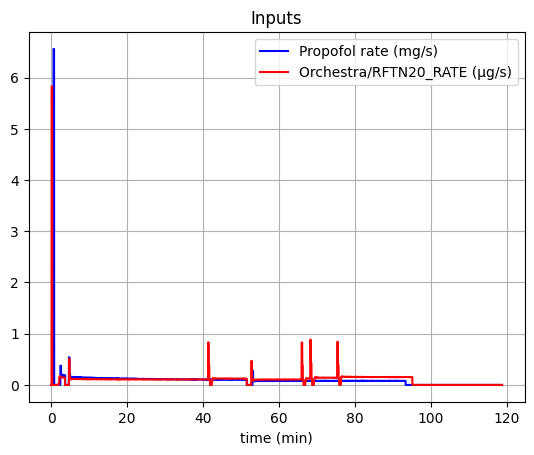

In [13]:
# plot the inputs
plt.figure()
plt.plot(df_results['Time']/60, case_df['Orchestra/PPF20_RATE']*20/3600,
         'b', label='Propofol rate (mg/s)')
plt.plot(df_results['Time']/60, case_df['Orchestra/RFTN20_RATE']*20/3600,
         'r', label='Orchestra/RFTN20_RATE (µg/s)')
plt.xlabel('time (min)')
plt.title('Inputs')
plt.legend()
plt.grid()
plt.show()


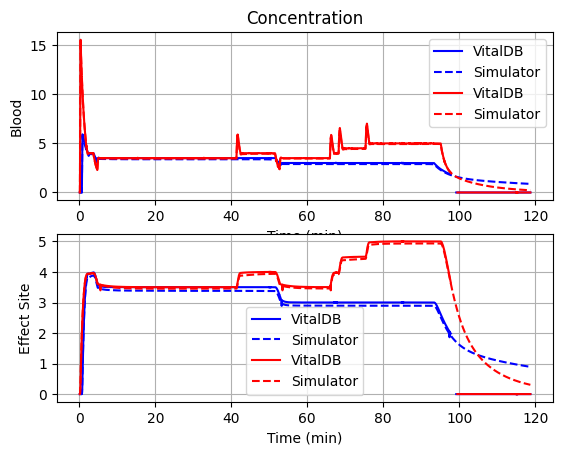

In [14]:
# plot Propofol Effect site concentration
fig, ax1 = plt.subplots(2)
ax1[0].plot(df_results['Time']/60, case_df['Orchestra/PPF20_CP'], 'b', label='VitalDB')
ax1[0].plot(df_results['Time']/60, df_results['x_propo_1'], 'b--', label='Simulator')
ax1[0].plot(df_results['Time']/60, case_df['Orchestra/RFTN20_CP'], 'r', label='VitalDB')
ax1[0].plot(df_results['Time']/60, df_results['x_remi_1'], 'r--', label='Simulator')
ax1[0].set_xlabel('Time (min)')
ax1[0].set_ylabel('Blood')
ax1[0].legend()
ax1[0].grid()
ax1[1].plot(df_results['Time']/60, case_df['Orchestra/PPF20_CE'], 'b', label='VitalDB')
ax1[1].plot(df_results['Time']/60, df_results['x_propo_4'], 'b--', label='Simulator')
ax1[1].plot(df_results['Time']/60, case_df['Orchestra/RFTN20_CE'], 'r', label='VitalDB')
ax1[1].plot(df_results['Time']/60, df_results['x_remi_4'], 'r--', label='Simulator')
ax1[1].set_xlabel('Time (min)')
ax1[1].set_ylabel('Effect Site')
ax1[0].set_title('Concentration')
ax1[1].legend()
ax1[1].grid()

Both simulation and data from vitalDB are quite similar, This was expected since the concentration are competed in by the TCI device using the same models than in PAS. The little difference might came from missing data or numerical approximation in the TCI device.

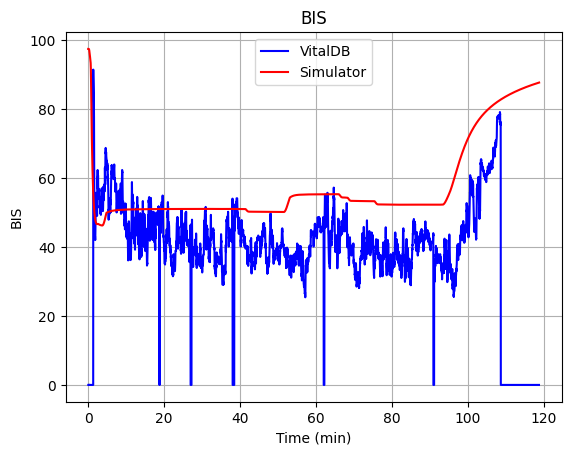

In [15]:
# plot BIS
plt.figure()
plt.plot(df_results['Time']/60, case_df['BIS/BIS'], 'b', label='VitalDB')
plt.plot(df_results['Time']/60, df_results['BIS'],  'r', label='Simulator')
plt.xlabel('Time (min)')
plt.ylabel('BIS')
plt.title('BIS')
plt.legend()
plt.grid()
plt.show()

Here we observe a huge difference between measured data and simulation. This can be explained by the fact that we are simulating a nominal model while the real patient have an individual reaction to drug. Moreover, the real patient is also subject to disturbance and the measure is subject to noise.